## LSTM regression
- 시계열 데이터에 대한 예측해보기
- 세계 항공 여행 승객 수 증가 데이터, 12개월치 승객 수 이용, 다음 달의 승객수 예측
- LSTM의 output range -1~1 이므로 인풋 normalize 필요
- [numpy 참고](http://eminentstar.tistory.com/25) 
- [seaborn 참고](https://datascienceschool.net/view-notebook/4c2d5ff1caab4b21a708cc662137bc65/)
- [keras lstm doc](https://keras.io/layers/recurrent/#lstm)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection # 학습/검증 데이터 나누기
from keras import models, layers
import seaborn as sns # 통계 그래프 패키지

from keraspp import skeras # 케라스 학습 결과 보여주기

Using TensorFlow backend.


In [2]:
class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        X, y = get_Xy(data_dn, D=D) # D만큼 잘라서 한 칸씩 옮겨가며 데이터셋을 만듬, D + 1값이 레이블
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

In [3]:
def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1) # dataframe -> numpy -> 1d reshape
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()
    
    data_nomalized = (data - np.mean(data)) / np.std(data) / 5 # tanh에 적합하게 -1 ~ 1 범위로 normalize
    plt.plot(data_nomalized)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passenger')
    plt.title('Normalized data by $E[]$ and $sigma$')
    plt.show()
    
    return data_nomalized

### 주의! LSTM은 3dim의 인풋을 기대합니다
- [이유](https://stackoverflow.com/questions/48475255/python-lstm-based-rnn-required-3d-input)
- (batch_size, timesteps, input_dim)

길이 2짜리 시계열 생성할 때, 인덱스 헷갈리네
- [1:3] -> 1,2  == [1:1+2]
- [1+2] -> 3
- 길이 5 배열이라면 5 - 2 - 1 == 2, [0,1]->2, [1,2]->3, [2,3]->4 까지만 돌아야 하니까

In [4]:
def get_Xy(data, D=12):
    X_list = []
    y_list = []
    N = len(data)
    assert N > D, "N should be longer than D, where N is len(data)"
    for i in range(N-D-1):
        X_list.append(data[i:i+D])
        y_list.append(data[i+D])
    X = np.array(X_list) # (130, 12)
    X = X.reshape(X.shape[0], X.shape[1], 1) # (130, 12, 1)
    y = np.array(y_list)
    print(X.shape, y.shape)
    return X, y

In [5]:
class Machine():
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:] # 샘플 데이터 수는 필요 없음
        self.model = rnn_model(shape)
    
    def run(self, epochs=400):
        d = self.data
        X_train, X_test = d.X_train, d.X_test
        y_train, y_test = d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)
        
        skeras.plot_loss(h)
        plt.title('History of training')
        plt.show()
        
        yp = m.predict(X_test) # yp의 shape는 (26, 1)
        print('Loss', m.evaluate(X_test, y_test))
        plt.plot(yp, label='Orignal')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()
        
        yp = m.predict(X_test).reshape(-1) # yp shaep는 (26,)
        print('Loss:', m.evaluate(X_test, y_test))
        print(yp.shape, y_test.shape)
        
        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)
        
        plt.figure(figsize=(7,5))
        sns.barplot(x='Sample', y='Normalized #Passengers',
                   hue='Type', data=df)
        plt.ylabel('Normalized #Passenger')
        plt.show()
        
        yp = m.predict(X)
        
        plt.plot(yp, label='Original')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()

### LSTM
- (참고) LSTM과 출력 계층 사이에 가중치 수 11개로 표시되는데, 1개는 바이어스임
- 내가 알고 있던 모양과 연관지어 생각하려 했는데 어렵다... 
- timesteps 개수만큼 자동으로 cell이 펼쳐지려나?
- units에 전달한 개수만큼, 중간은 무시하고 마지막 timestep의 output값을 얻을 수 있는 듯하다
- 관련 질문: [어떻게 중간 timesteps의 state를 얻을 수 있나?](https://github.com/keras-team/keras/issues/9202)

In [6]:
def rnn_model(shape):
    print("rnn input shape:", shape)
    m_x = layers.Input(shape=shape) # (timesteps, data_dim), (12, 1), batch_size 에 대한건 필요 없는 듯
    m_h = layers.LSTM(10)(m_x) # units: Positive integer, dimensionality of the output space.
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y) # 입출력의 모양으로써 모델 정의
    m.compile('adam', 'mean_squared_error') # 모델 정의 후 컴파일
    m.summary() # 모델에 대한 요약 정보 출력
    return m

In [7]:
def main():
    machine = Machine()
    machine.run(epochs=400)

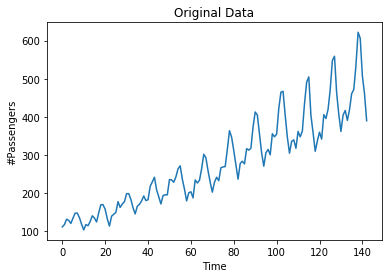

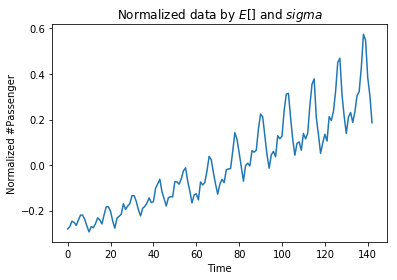

(130, 12, 1) (130,)
rnn input shape: (12, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


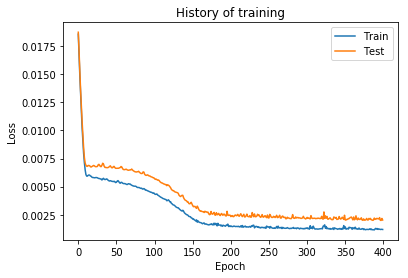

26/26 [==============================] - 0s 65us/step
Loss 0.0020340539049357176


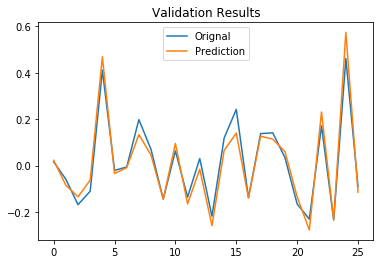

26/26 [==============================] - 0s 65us/step
Loss: 0.0020340539049357176
(26,) (26,)


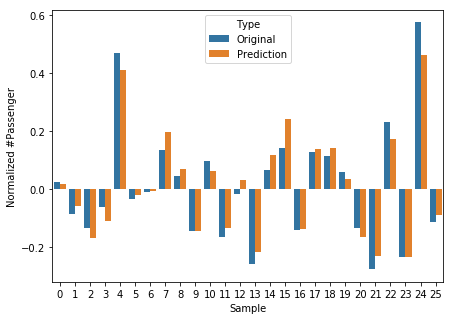

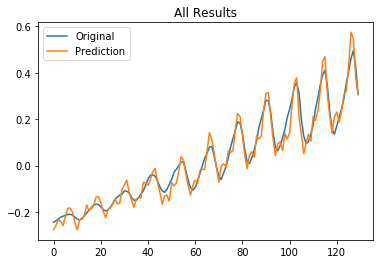

In [8]:
main()